In [11]:
import os
import sys
import json
import time
import warnings

warnings.filterwarnings('ignore')

python_working_dir = !pwd
package_path = '/'.join(python_working_dir[0].split('/')[:-1])
print(package_path)

sys.path.append(package_path)

import shap
import pandas as pd

from fraud_prevention import config
from fraud_prevention.features import dataset
from fraud_prevention.models import model_experiment
from fraud_prevention.evaluation import threshold_table as threshold_table_module

from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score

/Users/luis.sanchez/conekta/project


In [2]:
pipelines, param_grids = model_experiment.get_model_candidates()

for model, grid in param_grids.items():
    print(f"{model}\n{grid}\n")

logistic_regression
{'model__C': [0.1, 1, 10], 'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear']}

logistic_regression_SMOTE
{'model__C': [0.1, 1, 10], 'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear']}

lightgbm
{'model__learning_rate': [0.01, 0.05], 'model__max_depth': [5, 10], 'model__colsample_bytree': [0.6], 'model__min_child_samples': [50], 'model__n_estimators': [1000], 'model__reg_alpha': [1], 'model__reg_lambda': [0]}

lightgbm_SMOTE
{'model__learning_rate': [0.01, 0.05], 'model__max_depth': [5, 10], 'model__colsample_bytree': [0.6], 'model__min_child_samples': [50], 'model__n_estimators': [1000], 'model__reg_alpha': [1], 'model__reg_lambda': [0]}



In [3]:
(
    X_train, X_test, X_val,
    y_train, y_test, y_val,
    w_train, w_test, w_val
) = dataset.get(
    test_size=0.1, 
    val_size=.3)

pd.DataFrame([
    {
        "name": "train", 
        "size": X_train.shape[0], 
        "pos_class": (y_train == 1).sum(), 
        "new_class": (y_train == 0).sum()
    },
    {
        "name": "val", 
        "size": X_val.shape[0], 
        "pos_class": (y_val == 1).sum(), 
        "new_class": (y_val == 0).sum()
    },
    {
        "name": "test", 
        "size": X_test.shape[0], 
        "pos_class": (y_test == 1).sum(), 
        "new_class": (y_test == 0).sum()
    }, 
]).set_index('name')

,size,pos_class,new_class
name,,,
train,126324,313,126011
val,54139,133,54006
test,28481,46,28435


In [4]:
# Scorer definitions
f1_scorer = make_scorer(f1_score)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Train models with cross-validation and hyperparameter tuning
results = {}
for model_name, pipeline in pipelines.items():
    start = time.time()
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        scoring={'F1': f1_scorer, 'ROC_AUC': roc_auc_scorer},
        refit='ROC_AUC',
        cv=3,
        n_jobs=-1
    )
    
    if model_name in ['xgboost', 'lightgbm']:
        grid_search.fit(
            X_train,
            y_train,
            model__verbose=False,
            model__eval_set=[(X_train, y_train), (X_val, y_val)],
            model__early_stopping_rounds=10)
    else:
        grid_search.fit(
            X_train,
            y_train)
        
    end = time.time()

    grid_search_elapsed_time = round((end - start) / 60, 2)
    
    # Best model and performance
    best_model = grid_search.best_estimator_

    results[model_name] = {
        'f1_score': cross_val_score(
                best_model,
                X_test,
                y_test,
                scoring=f1_scorer,
                cv=5
            ).mean(),
        'roc_auc': cross_val_score(
                best_model,
                X_test,
                y_test,
                scoring=roc_auc_scorer,
                cv=5
            ).mean(),
        'elapsed_time': grid_search_elapsed_time,
        'best_model': best_model,
        'best_params': grid_search.best_params_
    }

Training logistic_regression...
Training logistic_regression_SMOTE...
Training lightgbm...
Training lightgbm_SMOTE...


In [5]:
results_df = pd.DataFrame(results).T.sort_values('roc_auc')

# Display results
for model, result in results.items():
    print(f"Model: {model} ({result['elapsed_time']}min)")
    print(f"F1 Score: {result['f1_score']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")
    print(f"Best Parameters: {result['best_params']}")

Model: logistic_regression (0.42min)
F1 Score: 0.7119
ROC-AUC: 0.9809
Best Parameters: {'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Model: logistic_regression_SMOTE (2.15min)
F1 Score: 0.3336
ROC-AUC: 0.9396
Best Parameters: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Model: lightgbm (0.53min)
F1 Score: 0.8064
ROC-AUC: 0.9929
Best Parameters: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__min_child_samples': 50, 'model__n_estimators': 1000, 'model__reg_alpha': 1, 'model__reg_lambda': 0}
Model: lightgbm_SMOTE (0.78min)
F1 Score: 0.8489
ROC-AUC: 0.9989
Best Parameters: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_samples': 50, 'model__n_estimators': 1000, 'model__reg_alpha': 1, 'model__reg_lambda': 0}


In [6]:
print(f'BEST MODEL: {results_df.index[-1]}')

results_df.iloc[-1]['best_params']

BEST MODEL: lightgbm_SMOTE


{'model__colsample_bytree': 0.6,
 'model__learning_rate': 0.01,
 'model__max_depth': 5,
 'model__min_child_samples': 50,
 'model__n_estimators': 1000,
 'model__reg_alpha': 1,
 'model__reg_lambda': 0}

# Save model score

In [9]:
DATA_PATH = os.path.join(
    config.PRJ_DIR,
    'models/data.parquet')

best_model = results_df.iloc[-1]['best_model']

X_train['name'] = 'train'
X_val['name'] = 'val'
X_test['name'] = 'test'

data = pd.concat([X_train, X_val, X_test])

data['y_score'] = best_model.predict_proba(
    data.drop(columns=['name'])
)[:, 1]

data['y_true'] = pd.concat([y_train, y_val, y_test])

data.to_parquet(DATA_PATH)

# Feature Importance

In [12]:
sample_size = 5_000

X_shap = pd.concat([
    data.query('y_true == 0').sample(sample_size),
    data.query('y_true == 1')
]).drop(columns=['name'])

explainer = shap.Explainer(
    best_model.steps[-1][-1],
    X_shap)

shap_values = explainer(
    X_shap)

100%|===================| 5477/5492 [01:28<00:00]        

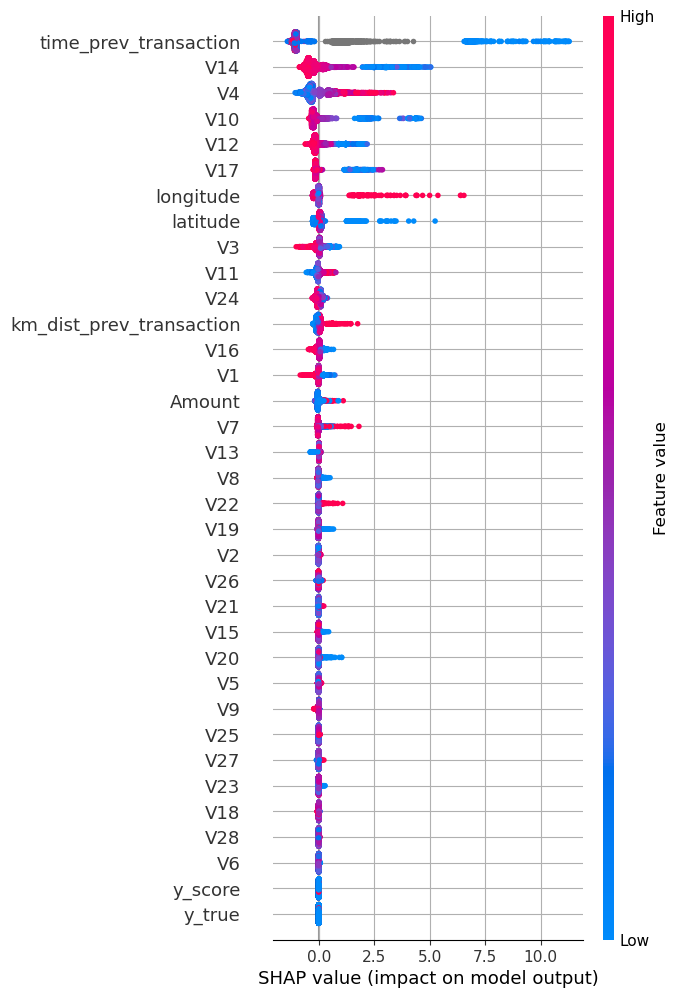

In [13]:
shap.plots.beeswarm(
    shap_values,
    plot_size=(5, 12),
    max_display=50)